In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.close('all')

def freestream_phi(V,z):
    complex_phi = V*z
    return complex_phi

def source_phi(strength,location,z):
    complex_phi = (strength/np.pi)*np.log(z - location)
    return complex_phi

def vortex_phi(strength,location,z):
    complex_phi = 1j*strength/(2*np.pi)*np.log((z-location)/location)
    return complex_phi

def vortexpanel_vel(gamma,start,end,z):
    theta=np.arctan2((end.imag-start.imag),(end.real-start.real))
#     print(theta)
#     theta=(np.log(end-start)).imag
#     print(theta)
    l=np.abs(end-start)
    print(l)
    zprime=(z-start)*np.exp(-1j*theta)
    complex_vel=1j*gamma/(2*np.pi)*np.log((zprime-l)/zprime)*np.exp(-1j*theta)
    return complex_vel.conjugate()


def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def source_velocity(z, z_src, strength):
    vel = strength/(2*np.pi*(z - z_src))
    return vel.conjugate()

def vortex_velocity(z, z_vor, gamma):
    return (-1j*gamma/(2*np.pi*(z - z_vor))).conjugate()

# def vortexpanel_velocity(z,start,end,gamma):
#     vel=-1j*gamma/(2*np.pi*(z-(end-start)))
#     return vel
    


def euler_integrate(z,z_src,strength,V, dt ,tf,sv_flag=1):
    result = [z]
    t=0.0
    while t<tf:
        vel = get_velocity(z,z_src,strength,V,sv_flag) 
        z += vel*dt
        result.append(z.copy())
        t += dt
    return np.asarray(result)

def rk2_integrate(z,z_src,strength,V, dt ,tf,sv_flag=1):
    result = [z]
    t = 0.0
    while t < tf:
        vel = get_velocity(z, z_src, strength, V,sv_flag)
        k1 = vel*dt
        z += k1
        vel = get_velocity(z, z_src, strength, V,sv_flag)
        k2 = vel*dt
        z += 0.5*(-k1 + k2) 
        result.append(z.copy()) 
        t += dt
    return np.asarray(result)

def get_velocity(z,z_src,strength,V,sv_flag):
    vel = np.zeros_like(z)
    if sv_flag:
        get_vel=source_velocity
    else:
        get_vel=vortex_velocity
    
    for i,z_i in enumerate(z):
        for j,z_j in enumerate(z_src):
            if z_i != z_j:
                vel[i] += get_vel(z_i,z_j,strength[j])              
    vel += V    
    return vel


def create_tracers(x_low = -2,x_up = -2.0, y_low = -2,y_up = 2,n = 10):
    if x_low == x_up:
        x = x_low*np.ones(n)
    else:
        x =np.linspace(x_low,x_up,n)
    y = np.linspace(y_low,y_up,n) 
    z = x +1j*y
    return z




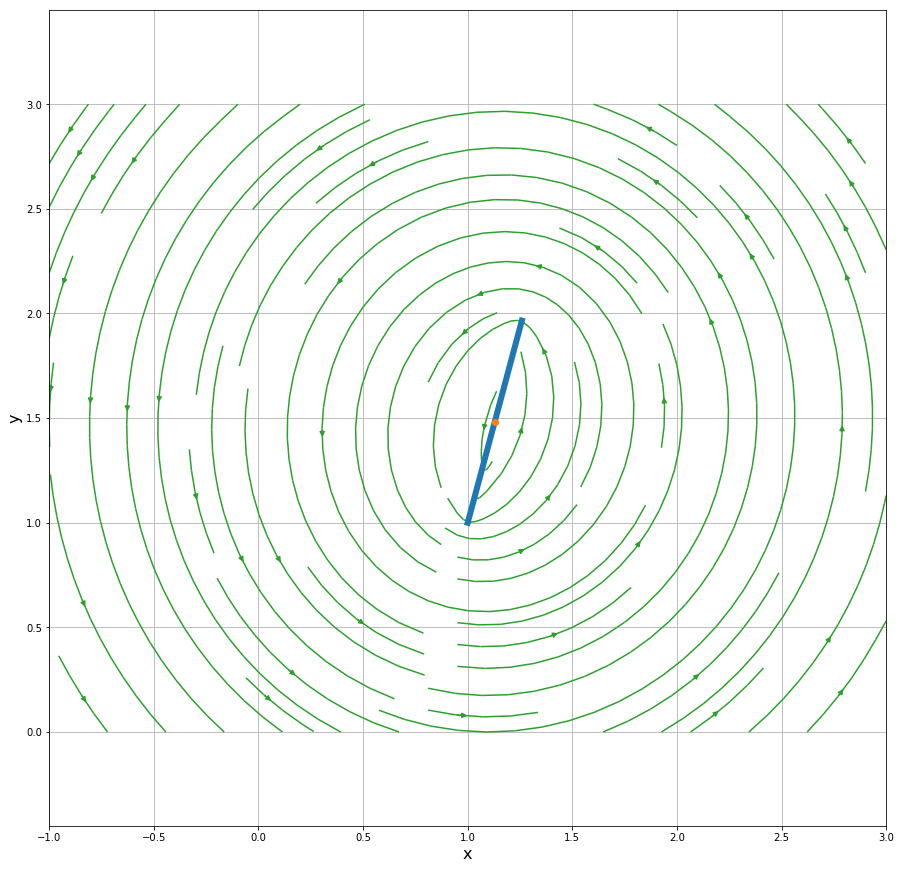

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
plt.ion()

V = complex(0,0)

class Panel:
    def __init__(self,start,end,strength=0):
        self.start=start
        self.end=end
        self.l=np.abs(end-start)
        self.t=((self.end-self.start)/abs(self.end-self.start))
        self.contol_point=0.5*(self.start+self.end)
        self.strength=strength
        
#         self.theta=np.arctan2((self.end.imag-self.start.imag),(self.end.real-self.start.real))
        
    def vortexpanel_coeff(self,field):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_coef=1j/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.coeff=complex_coef.conjugate()
        return complex_coef.conjugate()
    
    def vortexpanel_vel(self,field,strength):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_vel=1j*strength/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.complex_vel=complex_vel.conjugate()
        return complex_vel.conjugate()

    
    def panel_normal(self,origin):
        self.normal=(self.contol_point-origin)/np.abs(self.contol_point-origin)

    def draw(self):
        plt.plot([self.start.real,self.end.real],[self.start.imag,self.end.imag],linewidth=6)
        plt.plot(self.contol_point.real,self.contol_point.imag,'o')
        
def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def single_panel(angle=0):
    plt.close('all')

    gamma=1.0
    angles=np.linspace(0,180,11)
    plt.figure(figsize=(15,15))
    # for angle in angels:


#     angle=25
    start=complex(1.0,1.0)
    end=complex(start.real+np.cos(angle*np.pi/180),start.imag+np.sin(angle*np.pi/180))

    z = create_mesh(x_low=-1,x_up=3,n_x=100, y_low=0,y_up=3,n_y=100)

    P=Panel(start,end)
    P.vortexpanel_vel(z,gamma)
    plt.figure(figsize=(15,15))
    P.draw()
    complex_vel = P.complex_vel+V#+freestream_phi(V,z) + 

    plt.xlabel("x",fontsize=16)
    plt.ylabel("y",fontsize=16)
    plt.streamplot(z.real,z.imag,complex_vel.real,complex_vel.imag)
    plt.axis('equal')
    plt.grid('on')

single_panel(angle=75)


99


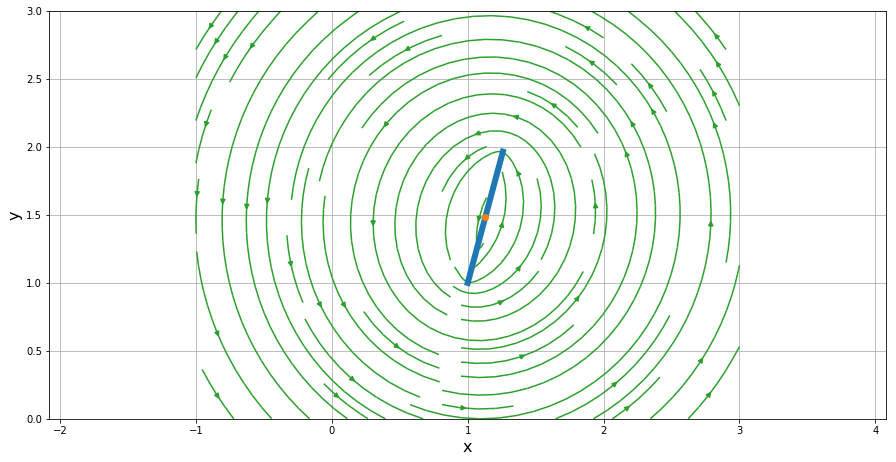

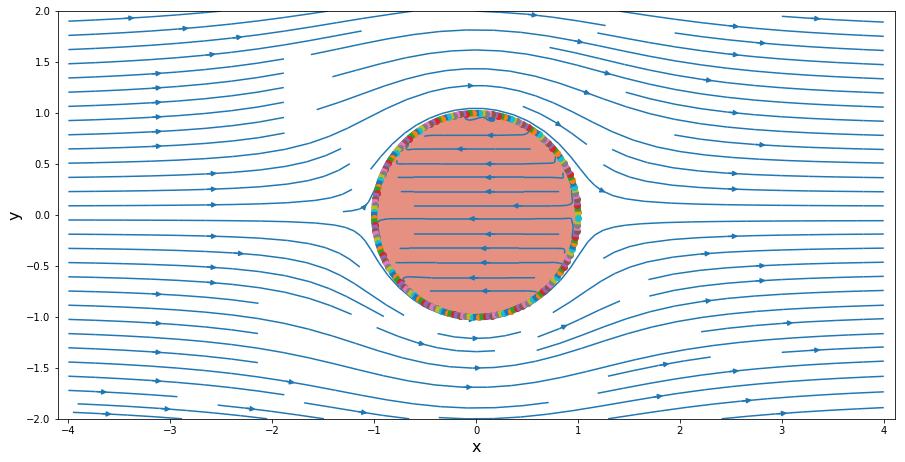

In [16]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
plt.ion()

V = complex(0,0)

class Panel:
    def __init__(self,start,end,strength=0):
        self.start=start
        self.end=end
        self.l=np.abs(end-start)
        self.t=((self.end-self.start)/abs(self.end-self.start))
        self.contol_point=0.5*(self.start+self.end)
        self.strength=strength
        
#         self.theta=np.arctan2((self.end.imag-self.start.imag),(self.end.real-self.start.real))
        
    def vortexpanel_coeff(self,field):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_coef=1j/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.coeff=complex_coef.conjugate()
        return complex_coef.conjugate()
    
    def vortexpanel_vel(self,field,strength):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_vel=1j*strength/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.complex_vel=complex_vel.conjugate()
        return complex_vel.conjugate()

    
    def panel_normal(self,origin):
        self.normal=(self.contol_point-origin)/np.abs(self.contol_point-origin)

    def draw(self):
        plt.plot([self.start.real,self.end.real],[self.start.imag,self.end.imag],linewidth=6)
        plt.plot(self.contol_point.real,self.contol_point.imag,'o')
        
def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def single_panel(angle=0):
    plt.close('all')

    gamma=1.0
    angles=np.linspace(0,180,11)
    plt.figure(figsize=(15,15))
    # for angle in angels:


#     angle=25
    start=complex(1.0,1.0)
    end=complex(start.real+np.cos(angle*np.pi/180),start.imag+np.sin(angle*np.pi/180))

    z = create_mesh(x_low=-1,x_up=3,n_x=100, y_low=0,y_up=3,n_y=100)

    P=Panel(start,end)
    P.vortexpanel_vel(z,gamma)
    plt.figure(figsize=(15,7.5))
    P.draw()
    complex_vel = P.complex_vel+V#+freestream_phi(V,z) + 

    plt.xlabel("x",fontsize=16)
    plt.ylabel("y",fontsize=16)
    plt.streamplot(z.real,z.imag,complex_vel.real,complex_vel.imag)
    plt.axis('equal')
    plt.grid('on')

single_panel(angle=75)


def complex_mult(a,b):
    return a.real*b.real+a.imag*b.imag

def assemble_coeff_mat():   
    cm=np.zeros([no_panels,no_panels],dtype=complex)
    for i in range(no_panels):
        for j in range(no_panels):
            cm[i,j]=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point),Ps[i].normal)
    return cm


def assemble_b_mat():
    bm=np.zeros([no_panels,1],dtype=complex)
    for i in range(no_panels):
        bm[i]=-complex_mult(V,Ps[i].normal)
    return bm

def generate_panels(no_panels,radius,origin):
    radians = np.linspace(0,2*np.pi,no_panels+1) 
    points = origin + radius*(np.cos(radians) +1j*np.sin(radians))
    end = points[1:]
    start = points[:-1]
    Ps=[]
    for i in range(no_panels):
        Ps.append(Panel(start[i],end[i]))
        Ps[i].panel_normal(origin)
        Ps[i].draw()
    return Ps
        
no_panels=100
radius=1.0
origin=complex(0,0)
plt.figure(figsize=(15,7.5))

Ps=generate_panels(no_panels,radius,origin)

V=complex(1.0,0)

z = create_mesh(x_low=-4+origin.real,x_up=4+origin.real,n_x=100, y_low=-2+origin.imag,y_up=2+origin.imag,n_y=100)


cm=assemble_coeff_mat()
bm=assemble_b_mat().real

for i in range(no_panels):
    cm[-1,i]=Ps[i].l
bm[-1]=0

rank=np.linalg.matrix_rank(cm)
print(rank)

gamma_mat=np.linalg.solve(cm,bm)
# print(gamma_mat)

Comple_vel=V
for i in range(no_panels):
    Ps[i].vortexpanel_vel(z,gamma_mat[i])
    Comple_vel+=Ps[i].complex_vel
    

plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.streamplot(z.real,z.imag,Comple_vel.real,Comple_vel.imag)
plt.axis('equal')
circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#CD2305', alpha=0.5)
plt.gca().add_patch(circle)


35


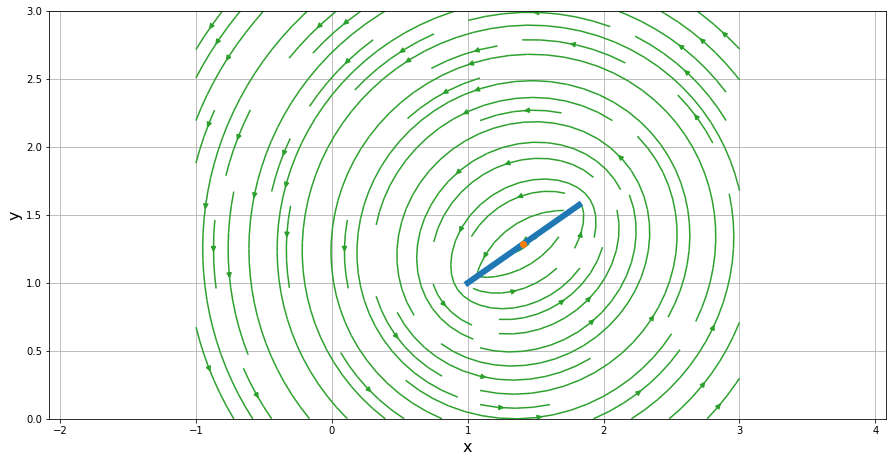

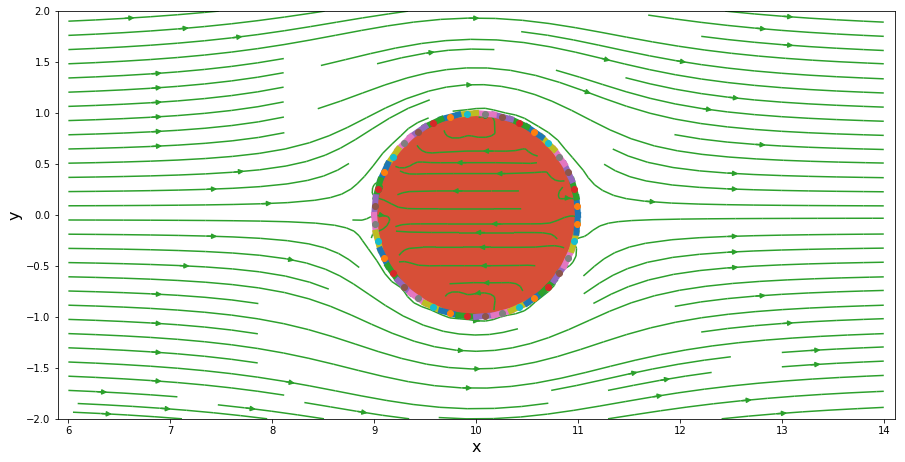

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
plt.ion()

V = complex(0,0)

class Panel:
    def __init__(self,start,end,strength=0):
        self.start=start
        self.end=end
        self.l=np.abs(end-start)
        self.t=((self.end-self.start)/abs(self.end-self.start))
        self.contol_point=0.5*(self.start+self.end)
        self.strength=strength
        
#         self.theta=np.arctan2((self.end.imag-self.start.imag),(self.end.real-self.start.real))
        
    def vortexpanel_coeff(self,field):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_coef=1j/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.coeff=complex_coef.conjugate()
        return complex_coef.conjugate()
    
    def vortexpanel_vel(self,field,strength):
        zprime=(field-self.start)*self.t.conjugate()#np.exp(-1j*self.theta)
        complex_vel=1j*strength/(2*np.pi)*np.log((zprime-self.l)/zprime)*self.t.conjugate()#*np.exp(-1j*self.theta)
        self.complex_vel=complex_vel.conjugate()
        return complex_vel.conjugate()

    
    def panel_normal(self,origin):
        self.normal=(self.contol_point-origin)/np.abs(self.contol_point-origin)

    def draw(self):
        plt.plot([self.start.real,self.end.real],[self.start.imag,self.end.imag],linewidth=6)
        plt.plot(self.contol_point.real,self.contol_point.imag,'o')
        
def create_mesh(x_low = -2, x_up = 2,n_x = 100,y_low = -2, y_up = 2,n_y = 100 ):
    "create_mesh(x_low, x_up, n_x, y_low, y_up, n_y) \
    Leave empty to use the default values"
    x = np.linspace(x_low,x_up,n_x)
    y = np.linspace(y_low,y_up,n_y)
    X,Y = np.meshgrid(x,y)
    z = X+1j*Y
    return z

def single_panel(angle=0):
    plt.close('all')

    gamma=1.0
    angles=np.linspace(0,180,11)
    plt.figure(figsize=(15,15))
    # for angle in angels:


#     angle=25
    start=complex(1.0,1.0)
    end=complex(start.real+np.cos(angle*np.pi/180),start.imag+np.sin(angle*np.pi/180))

    z = create_mesh(x_low=-1,x_up=3,n_x=100, y_low=0,y_up=3,n_y=100)

    P=Panel(start,end)
    P.vortexpanel_vel(z,gamma)
    plt.figure(figsize=(15,7.5))
    P.draw()
    complex_vel = P.complex_vel+V#+freestream_phi(V,z) + 

    plt.xlabel("x",fontsize=16)
    plt.ylabel("y",fontsize=16)
    plt.streamplot(z.real,z.imag,complex_vel.real,complex_vel.imag)
    plt.axis('equal')
    plt.grid('on')


def complex_mult(a,b):
    return a.real*b.real+a.imag*b.imag

def assemble_coeff_mat(Ps):
    no_panels=len(Ps)
    cm=np.zeros([no_panels,no_panels],dtype=complex)
    for i in range(no_panels):
        for j in range(no_panels):
            cm[i,j]=complex_mult(Ps[j].vortexpanel_coeff(Ps[i].contol_point),Ps[i].normal)
    return cm


def assemble_b_mat(Ps,V):
    no_panels=len(Ps)
    bm=np.zeros([no_panels,1],dtype=complex)
    for i in range(no_panels):
        bm[i]=-complex_mult(V,Ps[i].normal)
    return bm

def generate_panels(no_panels,radius,origin):
    radians = np.linspace(0,2*np.pi,no_panels+1) 
    points = origin + radius*(np.cos(radians) +1j*np.sin(radians))
    end = points[1:]
    start = points[:-1]

    plt.figure(figsize=(15,7.5))
    Ps=[]
    for i in range(no_panels):
        Ps.append(Panel(start[i],end[i]))
        Ps[i].panel_normal(origin)
        Ps[i].draw()
    return Ps

def problem1():
    no_panels=36
    radius=1.0
    origin=complex(10,0)
    Vinf=complex(1.0,0)

    z = create_mesh(x_low=-4+origin.real,x_up=4+origin.real,n_x=100, y_low=-2+origin.imag,y_up=2+origin.imag,n_y=100)

    Ps=generate_panels(no_panels,radius,origin)

    cm=assemble_coeff_mat(Ps)
    bm=assemble_b_mat(Ps,Vinf).real

    for i in range(no_panels):
        cm[-1,i]=Ps[i].l
    bm[-1]=0

    rank=np.linalg.matrix_rank(cm)
    print(rank)

    gamma_mat=np.linalg.solve(cm,bm)
    # print(gamma_mat)

    Comple_vel=Vinf
    for i in range(no_panels):
        Ps[i].vortexpanel_vel(z,gamma_mat[i])
        Comple_vel+=Ps[i].complex_vel


    plt.xlabel("x",fontsize=16)
    plt.ylabel("y",fontsize=16)
    plt.streamplot(z.real,z.imag,Comple_vel.real,Comple_vel.imag)
    plt.axis('equal')
    circle = plt.Circle((origin.real,origin.imag), radius=radius, color='#CD2305', alpha=0.8)
    plt.gca().add_patch(circle)


single_panel(angle=35)
    
problem1()



In [11]:
import numpy as np
import matplotlib.pyplot as plt

npanels=35;
radius=1.0
winf=1.0
gamma=-10

# z=radius*exp(1j*[2.np.pi/n])
[2*np.pi/npanels,2*np.pi,2*np.pi/npanels]
z=radius*np.exp(1j*np.linspace(2*np.pi/npanels,2*np.pi,npanels+1))
# print(z,len(z))
start=range(npanels)
end=range(1,npanels+1)
# end.append(0)
# print start
# print end

k=z[end]
l=z[start]
dzds=(k-l)/np.abs(k-l)
# print l,len(l)
# print k,len(k)
# print(dzds,len(dzds))
zc=(l+k)*0.5#-1j*1e-4*(k-l)
# print(zc,len(zc))

cm=np.zeros([npanels,npanels],dtype=complex)
for i in range(npanels):
    cm[:,i]=-1j*np.log((zc[i]-l)/(zc[i]-k))/(2*np.pi)*dzds[start]*dzds[i]
    
res=(-winf*dzds).imag
# print res,len(res)  
# print cm
q=res/cm.imag
ut=np.dot(q,cm)+winf*dzds

ut
plt.streampolt(z)


array([[  60.84072779 -61.75926933j,   66.77696008 -61.85889057j,
          80.89436872 -53.75287947j, ...,   47.32948204 -83.83231549j,
          55.27456814 -74.20004832j,   59.05349491 -65.08763041j],
       [   0.70228998 -33.01924466j,    3.18701047 -35.70703965j,
           7.64107444 -38.18783267j, ...,   11.23732311 -43.31910822j,
          16.75932840 -35.37831438j,   16.81906219 -26.34625552j],
       [  26.80214336 +15.88035458j,   38.06623252 +35.72081882j,
          33.39261656 +35.88928514j, ...,   47.87305353 -21.7839492j ,
          56.83588534  -6.88955185j,   58.83363386 +12.85655433j],
       ..., 
       [ -40.95629419 +61.58439753j,  -63.03421108 +30.32877232j,
         -46.76432120 +47.74181133j, ...,  -24.93118971 +88.42531037j,
         -36.74169184 +82.46235152j,  -48.79332169 +70.27454314j],
       [  59.35639607+312.38099282j,   17.18379266+292.1177941j ,
           4.20681628+307.59727421j, ...,  195.01266768+312.27890951j,
         155.70132522+313.59727478